# K Nearest Neighbors Implementation

#### In this Jupyter notebook, I implement the K-Nearest Neighbors (KNN) algorithm and use it to classify horses based on medical features. The goal is to predict whether a sick horse will survive, using a dataset that includes real veterinary records from horses admitted for treatment.

#### The data contains a range of clinical measurements such as rectal temperature, heart rate, pain level, and peristalsis (gut sounds), along with a final outcome label indicating whether the horse lived, died, or was euthanized. 

#### Many features are categorical or ordinal, and the dataset includes missing values. These will be handled through discarding some features with a high rate of incompleteness and discarding individual entries.

#### In this notebook, I will:
#### - Clean and preprocess the dataset
#### - Implement the KNN algorithm 
#### - Use KNN to predict survival outcomes based on clinical features
#### - Evaluate performance using accuracy and a confusion matrix, with respect to K

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Import & Filter the Data

In [2]:
# Load the dataset
df = pd.read_csv("horse.csv")

# Drop less useful columns
df = df.drop(columns=[
    'hospital_number', 'lesion_1', 'lesion_2', 'lesion_3',
    'cp_data', 'nasogastric_reflux_ph', 'abdomo_appearance', 'abdomo_protein'
])

# Drop rows with any missing values in the remaining columns
df_clean = df.dropna().copy()
print("Shape after cleaning:", df_clean.shape)

Shape after cleaning: (52, 20)


#### Because of the decrease in entries from 299 to 52, I will use k-fold cross validation to be better able to test out different values of K for the KNN algorithm without it (hopefully) becoming unstable.

#### continue to preprocess the data by encoding categorical and ordinal data with numbers:

In [3]:
# Here is how the dataset looks, even after removing a lot of not-so-useful columns
print("First 12 rows of the dataset (there are not many numbers):")
display(df_clean.head(12))

First 12 rows of the dataset (there are not many numbers):


,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,outcome,surgical_lesion
6,yes,adult,37.9,48.0,16.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,moderate,none,none,decreased,distend_large,37.0,7.0,lived,yes
10,yes,adult,38.1,66.0,12.0,cool,reduced,bright_red,less_3_sec,mild_pain,hypomotile,none,slight,none,increased,distend_large,44.0,6.0,lived,yes
14,yes,adult,38.2,76.0,28.0,cool,normal,normal_pink,less_3_sec,mild_pain,absent,none,slight,less_1_liter,absent,distend_small,46.0,81.0,lived,yes
18,yes,adult,37.6,64.0,21.0,normal,normal,bright_pink,less_3_sec,depressed,hypomotile,none,none,none,increased,distend_large,40.0,7.0,lived,yes
20,yes,adult,39.9,72.0,60.0,normal,normal,bright_red,more_3_sec,extreme_pain,absent,severe,significant,none,absent,distend_small,46.0,6.1,lived,yes
26,yes,adult,38.3,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,none,decreased,distend_large,43.0,7.0,lived,yes
30,no,adult,37.7,96.0,30.0,cool,reduced,pale_cyanotic,more_3_sec,extreme_pain,absent,severe,significant,less_1_liter,absent,distend_large,66.0,7.5,died,yes
42,no,adult,38.0,60.0,12.0,cool,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,none,none,increased,other,47.0,7.0,lived,no
48,yes,adult,38.9,80.0,44.0,cool,reduced,pale_pink,more_3_sec,depressed,hypomotile,moderate,slight,less_1_liter,decreased,normal,54.0,6.5,died,yes
49,no,adult,37.2,84.0,48.0,cool,reduced,bright_red,more_3_sec,severe_pain,hypermotile,slight,none,less_1_liter,increased,normal,73.0,5.5,died,no


In [4]:
# Define mappings for categorical features
mappings = {
    'surgery': {'no': 0, 'yes': 1},
    'age': {'young': 0, 'adult': 1},
    'temp_of_extremities': {'normal': 1, 'warm': 2, 'cool': 3, 'cold': 4},
    'peripheral_pulse': {'normal': 1, 'increased': 2, 'reduced': 3, 'absent': 4},
    'mucous_membrane': {
        'normal_pink': 1,
        'bright_pink': 2,
        'pale_pink': 3,
        'pale_cyanotic': 4,
        'bright_red': 5,
        'dark_cyanotic': 6
    },
    'capillary_refill_time': {'less_3_sec': 1, 'more_3_sec': 2},
    'pain': {
        'alert': 1,
        'depressed': 2,
        'mild_pain': 3,
        'severe_pain': 4,
        'extreme_pain': 5
    },
    'peristalsis': {'hypermotile': 1, 'normal': 2, 'hypomotile': 3, 'absent': 4},
    'abdominal_distention': {'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4},
    'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2},
    'nasogastric_reflux': {'none': 0, 'less_1_liter': 1, 'more_1_liter': 2},
    'rectal_exam_feces': {
        'normal': 1,
        'increased': 2,
        'decreased': 3,
        'absent': 4
    },
    'abdomen': {
        'normal': 1,
        'firm': 2,
        'distend_small': 3,
        'distend_large': 4,
        'other': 5
    },
    'outcome': {'lived': 1, 'died': 0, 'euthanized': 0},  # Binary classification
    'surgical_lesion': {'no': 0, 'yes': 1}
}

# Apply mappings
for col, mapping in mappings.items():
    if col in df_clean.columns: #prevents mapping over map and getting NaNs
        if df_clean[col].dtype == 'object':  # only map if it's still categorical
            df_clean[col] = df_clean[col].map(mapping)

# Confirm encoding
print(df_clean.head(10))

    surgery  age  rectal_temp  pulse  respiratory_rate  temp_of_extremities  \
6         1    1         37.9   48.0              16.0                    1   
10        1    1         38.1   66.0              12.0                    3   
14        1    1         38.2   76.0              28.0                    3   
18        1    1         37.6   64.0              21.0                    1   
20        1    1         39.9   72.0              60.0                    1   
26        1    1         38.3   72.0              30.0                    4   
30        0    1         37.7   96.0              30.0                    3   
42        0    1         38.0   60.0              12.0                    3   
48        1    1         38.9   80.0              44.0                    3   
49        0    1         37.2   84.0              48.0                    3   

    peripheral_pulse  mucous_membrane  capillary_refill_time  pain  \
6                  1                1                      1

#### The fully preprocessed data is now ready to be used in the KNN Algorithm

## KNN Algorithm
First, we need to define the distance function

In [5]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

Then, we can create the KNN class:
### KNN Classifier

- `__init__(self, k)`: Initializes the classifier with a user-defined number of neighbors \( k \).
- `fit(self, X, y)`: Stores the training data (`X`) and corresponding labels (`y`). KNN is a lazy learner, so this is all the "training" it does — no fitting of parameters.
- `predict(self, X)`: Takes a matrix of test samples and returns a list of predictions, one for each test point, by applying `_predict()` to each row.
- `_predict(self, x)`: **The core of the algorithm**:
  - Computes the distance between the input test point `x` and every point in the training data.
  - Finds the indices of the `k` closest training samples.
  - Looks up their labels and returns the **most common label** as the prediction. This is why k must be odd.

This is how KNN works: it memorizes the training set, compares distances when it is time to predict a test point's classification, and classifies based on the most common label of its neighbors.

In [6]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        # Compute distances between x and all training samples
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Get the indices of the k nearest samples
        k_indices = np.argsort(distances)[:self.k]
        
        # Get the labels of the k nearest samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


### Finally, we Evaluate KNN...with 5-Fold Cross-Validation

Below, I use 5-fold cross-validation across a range of \( K \) values to evaluate my KNN implementation.

- First, I define the features `X` and labels `y` from the cleaned dataset, normalizing them.
This is important because KNN relies on distance, and uneven scales would make some metrics undeservedly more important in the eyes of the algorithm.
- I use `KFold` from `sklearn.model_selection` to split the data into 5 different folds, each time using 4 folds for training and 1 for testing. The `shuffle=True` ensures that the folds are randomized.

I test KNN for \( K = 1 \) to \( K = 10 \), and for each value:
- The model is trained on each of the 5 folds.
- Accuracy is calculated for each fold and then averaged across all 5.
- The final output is the mean accuracy for each \( K \), which we can later visualize to help choose the best-performing value.

In [15]:
# Define data
X = df_clean.drop(columns=['outcome']).values
y = df_clean['outcome'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 11)
mean_accuracies = []

# Loop over different K values for KNN
for k in k_values:
    fold_accuracies = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = KNN(k=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)
    
    mean_accuracy = np.mean(fold_accuracies)
    mean_accuracies.append(mean_accuracy)
    print(f"K = {k}, Mean Accuracy = {mean_accuracy:.4f}")


K = 1, Mean Accuracy = 0.6964
K = 2, Mean Accuracy = 0.6964
K = 3, Mean Accuracy = 0.6982
K = 4, Mean Accuracy = 0.7145
K = 5, Mean Accuracy = 0.7364
K = 6, Mean Accuracy = 0.7182
K = 7, Mean Accuracy = 0.6564
K = 8, Mean Accuracy = 0.7127
K = 9, Mean Accuracy = 0.7309
K = 10, Mean Accuracy = 0.6945


## Result

### Plotting Accuracy vs. K

This plot visualizes the relationship between the number of neighbors \( K \) and the classification accuracy of the KNN model.

- The x-axis represents the value of \( K \) (number of nearest neighbors considered).
- The y-axis shows the mean classification accuracy obtained from 5-fold cross-validation for each value of \( K \).

Each point on the plot corresponds to the average performance of the model across all folds. The goal is to identify the value of \( K \) that yields the **highest accuracy**, while avoiding values that may lead to overfitting (very low K) or underfitting (very high K).

According to this plot, the value of \( K \) that generalizes the best to new data is K = 5.


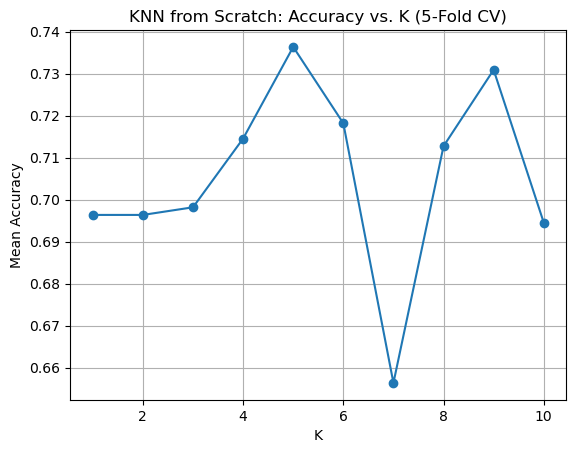

In [17]:
plt.plot(k_values, mean_accuracies, marker='o')
plt.title("KNN from Scratch: Accuracy vs. K (5-Fold CV)")
plt.xlabel("K")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

### Observations from the Accuracy vs. K Plot

The plot above shows how the mean accuracy of the KNN classifier (evaluated using 5-fold cross-validation) changes as we vary the number of neighbors \( K \). 

Acuracy improves slightly from \( K = 1 \) to around \( K = 5 \), where it reaches its peak. Then, accuracy drops sharply at \( K = 7 \), indicating that too much smoothing may reduce the model’s ability to capture local structure in the data. The performance recovers somewhat for higher K values, but remains lower than the peak at \( K = 5 \).

This suggests that \( K = 5 \) may be an optimal choice for balancing bias and variance in this dataset.

### Lastly, Confusion Matrices for K = 3 (5-Fold Cross-Validation)

In this section, we evaluate our from-scratch KNN classifier using 5-fold cross-validation with \( K = 3 \), and visualize the results using confusion matrices.

For each fold:
- The model is trained on 4/5 of the data and tested on the remaining 1/5.
- A **confusion matrix** is computed to show how well the model distinguishes between horses that survived and those that did not.
- The matrix is plotted as a labeled heatmap for easy interpretation, and the fold’s accuracy is printed below each plot.

These matrices allow us to see the specific types of prediction errors the model makes, false positives (predicts survival but horse died) or false negatives (predicts death but the horse survived).

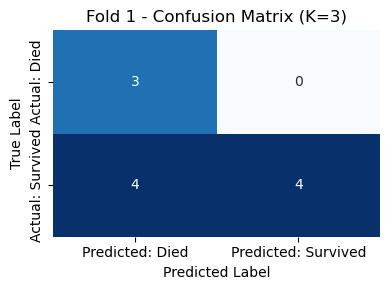

Fold 1 Accuracy: 0.6364



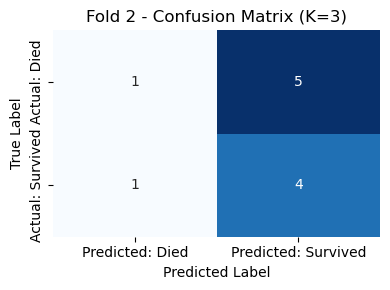

Fold 2 Accuracy: 0.4545



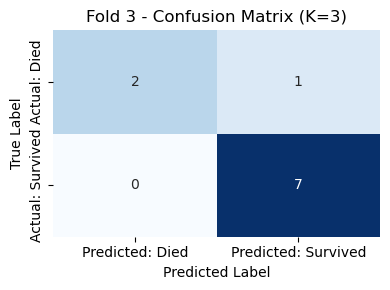

Fold 3 Accuracy: 0.9000



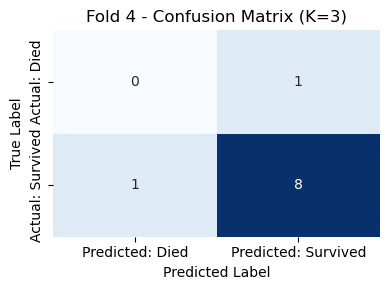

Fold 4 Accuracy: 0.8000



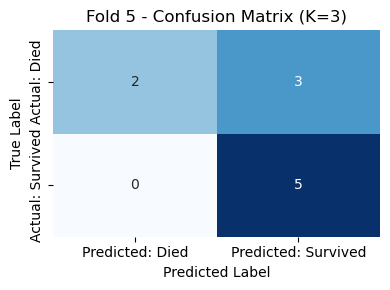

Fold 5 Accuracy: 0.7000



In [22]:
k = 3
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_num = 1

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = KNN(k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Plot nicely formatted confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: Died', 'Predicted: Survived'],
                yticklabels=['Actual: Died', 'Actual: Survived'])
    plt.title(f"Fold {fold_num} - Confusion Matrix (K={k})")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print(f"Fold {fold_num} Accuracy: {acc:.4f}\n")
    fold_num += 1


## Analysis & Discussion

### Cross-Validation Performance

Using 5-fold cross-validation, we evaluated KNN across values of \( K \) from 1 to 10. The plot of accuracy vs. \( K \) showed that model performance peaked around \( K = 5 \), with a mean accuracy close to 74%. This suggests that a moderate number of neighbors helps the model generalize better, reducing sensitivity to noise while still capturing local structure.

### Confusion Matrix Insights

To understand the model's predictions in more detail, we plotted confusion matrices for each fold at \( K = 3 \). These visualizations showed that the model tends to predict survival more often than death, which may reflect an imbalance in the dataset that could be corrected by sorting the training set in a better way. 

### Challenges and Limitations

- **Small Dataset**: After filtering for complete cases, only 52 data points remained. This makes cross-validation essential, but it also means that the model may not generalize well to other samples or real-world populations.
- **Categorical Encoding**: Many of the features required manual encoding. It was important not to misinterpret the features as being nominal or ordinal when they are not, since that plays a role in how we encode them. 
- **Missing Data**: The original dataset included many missing values. By dropping incomplete rows, we reduced noise but also lost potentially valuable information. In future versions, imputation strategies could help retain more data.